In [3]:
!pip install torch

  Using cached torch-2.6.0-cp310-cp310-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparselt_cu12-0.6.2-py3

In [4]:
# ==========================================
# File-level Wake vs No-Wake LSTM Classifier
# ==========================================
# Positives: processed_ts/{train,valid,test}/*.csv (drop files w/o ≥1 min wake)
# Negatives: vessel_NO_wake_timeseries/{train,valid,test}/*.txt (assumed no wake)
#
# Each file → one sample (sequence). Variable lengths → resampled to TARGET_LEN.
# ==========================================

import os, glob, random, math, json
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [5]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


In [6]:
# POSITIVE CSV root (already processed)
POS_ROOT = "processed_ts"  # expects train/valid/test subfolders with *.csv

# NEGATIVE TXT root (you just downloaded)
NEG_ROOT = os.path.join("..", "marinelabs-ml-deepsense-wake-detection-8ea2af3a69ac",
                        "data", "vessel_NO_wake_timeseries")

SAMPLES_PER_MIN = 300           # 1 minute == 300 samples (given 200 ms step)
MIN_WAKE_SAMPLES = SAMPLES_PER_MIN  # ≥ 1 minute contiguous = positive
TARGET_LEN = 3000               # 10 minutes @ 200 ms step; we resample every sequence to this length

# Training
LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 55
POS_WEIGHT = 2.0                # tilt toward recall; tune 1.5–3.0
WEIGHT_DECAY = 1e-4
GRAD_CLIP_NORM = 1.0
EARLY_STOP_PATIENCE = 7
VAL_METRIC = "F1"

In [7]:
def load_pos_csv(fp):
    """Load one positive CSV with columns ['t_s','z_m','wake_label'] and sort."""
    df = pd.read_csv(fp).sort_values("t_s").reset_index(drop=True)
    return df

def file_has_any_wake(df):
    w = df["wake_label"].to_numpy(dtype=np.int8)
    return int(w.max()) == 1

def file_has_long_wake(df, min_run=MIN_WAKE_SAMPLES):
    w = df["wake_label"].to_numpy(dtype=np.int8)
    best = cur = 0
    for v in w:
        if v == 1:
            cur += 1
            if cur > best: best = cur
        else:
            cur = 0
    return best >= min_run

def load_neg_txt(fp):
    """
    Load one negative TXT (JSON) file written by downloader.
    Expected keys: start_epoch_ms, num_timesteps, stepsize_ms, z_positions_m (list).
    """
    with open(fp, "r") as f:
        data = json.load(f)
    z = np.asarray(data["z_positions_m"], dtype=np.float32)
    return z

def resample_to_target_len(z, target_len=TARGET_LEN):
    """
    Resample 1D array z to target_len using linear interpolation.
    Works for both shorter and longer sequences.
    """
    if len(z) == target_len:
        return z.astype(np.float32)
    x_src = np.linspace(0.0, 1.0, num=len(z), endpoint=True)
    x_tgt = np.linspace(0.0, 1.0, num=target_len, endpoint=True)
    z_tgt = np.interp(x_tgt, x_src, z)
    return z_tgt.astype(np.float32)

def scan_split_files(root, exts):
    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(root, ext)))
    files.sort()
    return files

def split_dicts():
    return {"train": [], "valid": [], "test": []}

In [8]:
# -------------------------
# 3) Build file lists (positives & negatives per split)
# -------------------------
pos_files = {
    split: scan_split_files(os.path.join(POS_ROOT, split), ["*.csv"])
    for split in ("train", "valid", "test")
}
neg_files = {
    split: scan_split_files(os.path.join(NEG_ROOT, split), ["*.txt"])
    for split in ("train", "valid", "test")
}

# Filter positives: keep only files with ≥1-min contiguous wake
pos_files_filtered = split_dicts()
for split in ("train", "valid", "test"):
    kept = []
    for fp in pos_files[split]:
        try:
            df = load_pos_csv(fp)
            if file_has_any_wake(df):   # <-- changed
                kept.append(fp)
        except Exception as e:
            print(f"[WARN] Skipping {fp}: {e}")
    pos_files_filtered[split] = kept
    print(f"[POS] {split}: kept {len(kept)} / {len(pos_files[split])} files with ANY wake")

# Negatives are assumed no wake; just list count
for split in ("train", "valid", "test"):
    print(f"[NEG] {split}: {len(neg_files[split])} txt files found")


[POS] train: kept 9006 / 9909 files with ANY wake
[POS] valid: kept 3101 / 3411 files with ANY wake
[POS] test: kept 3112 / 6121 files with ANY wake
[NEG] train: 11975 txt files found
[NEG] valid: 4069 txt files found
[NEG] test: 7335 txt files found


In [9]:
# -------------------------
# 3b) Balance negatives to match positives (undersample)
# -------------------------
rng = np.random.default_rng(SEED)

neg_files_balanced = {"train": [], "valid": [], "test": []}
for split in ("train", "valid", "test"):
    pos_n = len(pos_files_filtered[split])
    neg_all = neg_files[split]
    if len(neg_all) < pos_n:
        print(f"[WARN] Not enough negatives in {split}: have {len(neg_all)}, need {pos_n}. Using all negatives.")
        neg_pick = neg_all  # will be smaller than positives
    else:
        idx = rng.choice(len(neg_all), size=pos_n, replace=False)
        neg_pick = [neg_all[i] for i in idx]
    neg_files_balanced[split] = neg_pick
    print(f"[BAL] {split}: pos={pos_n}, neg(before)={len(neg_all)}, neg(kept)={len(neg_pick)}")


[BAL] train: pos=9006, neg(before)=11975, neg(kept)=9006
[BAL] valid: pos=3101, neg(before)=4069, neg(kept)=3101
[BAL] test: pos=3112, neg(before)=7335, neg(kept)=3112


In [10]:
# -------------------------
# 4) Dataset (resample to fixed length)
# -------------------------
class FileLevelDataset(Dataset):
    def __init__(self, pos_list, neg_list, fit_scaler=False, scaler=None):
        """
        pos_list: list of CSV files (each contains ≥1-min wake)
        neg_list: list of TXT files (no wake)
        We resample every sequence to TARGET_LEN and then z-score scale (global scaler fitted on train).
        """
        self.samples = []  # list of (z, y, src_fp)
        self._raw = []     # keep raw prior to scaling, to fit scaler externally

        # positives
        for fp in pos_list:
            df = load_pos_csv(fp)
            z = df["z_m"].to_numpy(dtype=np.float32)
            z = resample_to_target_len(z, TARGET_LEN)
            self._raw.append(z)
            self.samples.append((None, 1, fp))  # fill z after scaling

        # negatives
        for fp in neg_list:
            try:
                z = load_neg_txt(fp)
                z = resample_to_target_len(z, TARGET_LEN)
                self._raw.append(z)
                self.samples.append((None, 0, fp))
            except Exception as e:
                print(f"[WARN] Skipping {fp}: {e}")

        # scale
        if fit_scaler:
            all_z = np.stack(self._raw, axis=0)  # (N, L)
            self.scaler = StandardScaler()
            all_z_scaled = self.scaler.fit_transform(all_z.reshape(-1, 1)).reshape(all_z.shape)
        else:
            if scaler is None:
                raise ValueError("scaler must be provided if fit_scaler=False")
            self.scaler = scaler
            all_z = np.stack(self._raw, axis=0)
            all_z_scaled = self.scaler.transform(all_z.reshape(-1, 1)).reshape(all_z.shape)

        # commit scaled sequences
        for i, (zsc, (_, y, fp)) in enumerate(zip(all_z_scaled, self.samples)):
            self.samples[i] = (zsc.astype(np.float32), y, fp)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        z, y, fp = self.samples[idx]
        # model expects shape (C=1, L)
        return torch.from_numpy(z[None, :]).float(), torch.tensor(float(y)).float(), fp

In [11]:
# -------------------------
# 5) Build datasets & loaders
# -------------------------
# Train first to fit scaler
train_ds = FileLevelDataset(pos_files_filtered["train"], neg_files_balanced["train"], fit_scaler=True)
scaler = train_ds.scaler

valid_ds = FileLevelDataset(pos_files_filtered["valid"], neg_files_balanced["valid"], fit_scaler=False, scaler=scaler)
test_ds  = FileLevelDataset(pos_files_filtered["test"],  neg_files_balanced["test"],  fit_scaler=False, scaler=scaler)

def loader(ds, shuffle):
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle, drop_last=False)

train_loader = loader(train_ds, True)
valid_loader = loader(valid_ds, False)
test_loader  = loader(test_ds,  False)

def stats(ds, name):
    ys = [int(y.item()) if isinstance(y, torch.Tensor) else int(y) for (_, y, _) in ds]
    c = Counter(ys)
    print(f"[STATS] {name}: N={len(ds)} | pos={c.get(1,0)} | neg={c.get(0,0)}")
stats(train_ds, "train")
stats(valid_ds, "valid")
stats(test_ds,  "test")

[STATS] train: N=18012 | pos=9006 | neg=9006
[STATS] valid: N=6202 | pos=3101 | neg=3101
[STATS] test: N=6224 | pos=3112 | neg=3112


In [12]:
# -------------------------
# 6) Model (LSTM + max pool)
# -------------------------
class LSTMWakeFile(nn.Module):
    def __init__(self, input_size=1, hidden=128, num_layers=2, bidir=True, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden, num_layers=num_layers,
            batch_first=True, bidirectional=bidir, dropout=dropout if num_layers>1 else 0.0
        )
        out_dim = hidden * (2 if bidir else 1)
        self.head = nn.Linear(out_dim, 1)

    def forward(self, x):  # x: (B,1,L)
        x = x.transpose(1, 2)       # (B,L,1)
        h, _ = self.lstm(x)         # (B,L,H*)
        hmax = h.max(dim=1).values  # max-pool over time
        logit = self.head(hmax).squeeze(1)
        return logit

model = LSTMWakeFile().to(device)
pos_weight = torch.tensor(1.0, dtype=torch.float32, device=device)
criterion  = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=3)


In [13]:
# -------------------------
# 7) Metrics
# -------------------------
def compute_metrics(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {"Accuracy":acc, "Precision":p, "Recall":r, "F1":f1, "TP":int(tp), "FP":int(fp),
            "TN":int(tn), "FN":int(fn)}

def eval_loader(model, loader, thr=0.5):
    model.eval()
    losses, y_true, y_prob = [], [], []
    with torch.no_grad():
        for xb, yb, _ in loader:
            xb = xb.to(device); yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            losses.append(loss.item())
            prob = torch.sigmoid(logits).detach().cpu().numpy()
            y_prob.append(prob)
            y_true.append(yb.detach().cpu().numpy())
    y_true = np.concatenate(y_true).astype(int)
    y_prob = np.concatenate(y_prob)
    metrics = compute_metrics(y_true, y_prob, thr=thr)
    return float(np.mean(losses)), y_true, y_prob, metrics

def best_threshold(y_true, y_prob):
    ts = np.linspace(0.05, 0.95, 19)
    best = (0.5, -1, 0, 0)
    for t in ts:
        m = compute_metrics(y_true, y_prob, thr=t)
        if m["F1"] > best[1]:
            best = (t, m["F1"], m["Precision"], m["Recall"])
    return best  # thr, F1, P, R

In [ ]:
# -------------------------
# 8) Train
# -------------------------
best_state = None
best_val = -1.0
no_improve = 0
thr_used = 0.5

for epoch in range(1, EPOCHS+1):
    # train
    model.train()
    train_losses = []
    for xb, yb, _ in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = float(np.mean(train_losses))

    # validate
    val_loss, yv_true, yv_prob, val_metrics = eval_loader(model, valid_loader, thr=0.5)
    # threshold sweep for reporting + scheduler target
    thr, f1b, pb, rb = best_threshold(yv_true, yv_prob)
    thr_used = thr
    scheduler.step(f1b)

    print(f"Epoch {epoch:03d} | TrainLoss {train_loss:.4f} | ValLoss {val_loss:.4f} "
          f"| Val(F1/P/R @bestThr={thr:.2f}) {f1b:.3f}/{pb:.3f}/{rb:.3f}")

    # early stopping on best F1
    if f1b > best_val + 1e-6:
        best_val = f1b
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= EARLY_STOP_PATIENCE:
            print(f"[INFO] Early stop at epoch {epoch}, best Val F1={best_val:.3f}")
            break

if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    torch.save(model.state_dict(), "lstm_file_best.pt")

Epoch 001 | TrainLoss 0.5582 | ValLoss 0.5063 | Val(F1/P/R @bestThr=0.40) 0.772/0.685/0.885
Epoch 002 | TrainLoss 0.5018 | ValLoss 0.4628 | Val(F1/P/R @bestThr=0.55) 0.805/0.759/0.858


In [ ]:
# Epoch 001 | TrainLoss 0.5582 | ValLoss 0.5063 | Val(F1/P/R @bestThr=0.40) 0.772/0.685/0.885
# Epoch 002 | TrainLoss 0.5018 | ValLoss 0.4628 | Val(F1/P/R @bestThr=0.55) 0.805/0.759/0.858
# Epoch 003 | TrainLoss 0.4185 | ValLoss 0.3874 | Val(F1/P/R @bestThr=0.50) 0.832/0.819/0.846
# Epoch 004 | TrainLoss 0.3509 | ValLoss 0.3296 | Val(F1/P/R @bestThr=0.50) 0.871/0.827/0.921
# Epoch 005 | TrainLoss 0.3183 | ValLoss 0.3209 | Val(F1/P/R @bestThr=0.65) 0.882/0.888/0.876
# Epoch 006 | TrainLoss 0.2928 | ValLoss 0.2603 | Val(F1/P/R @bestThr=0.50) 0.903/0.883/0.923
# Epoch 007 | TrainLoss 0.2549 | ValLoss 0.2599 | Val(F1/P/R @bestThr=0.55) 0.899/0.864/0.938
# Epoch 008 | TrainLoss 0.2428 | ValLoss 0.3169 | Val(F1/P/R @bestThr=0.15) 0.904/0.871/0.941
# Epoch 009 | TrainLoss 0.2360 | ValLoss 0.2308 | Val(F1/P/R @bestThr=0.60) 0.910/0.899/0.921
# Epoch 010 | TrainLoss 0.2241 | ValLoss 0.2313 | Val(F1/P/R @bestThr=0.40) 0.910/0.912/0.908
# Epoch 011 | TrainLoss 0.3683 | ValLoss 0.3806 | Val(F1/P/R @bestThr=0.55) 0.830/0.839/0.822
# Epoch 012 | TrainLoss 0.4284 | ValLoss 0.4408 | Val(F1/P/R @bestThr=0.55) 0.826/0.756/0.909
# Epoch 013 | TrainLoss 0.3942 | ValLoss 0.3441 | Val(F1/P/R @bestThr=0.60) 0.852/0.868/0.836
# Epoch 014 | TrainLoss 0.3126 | ValLoss 0.2766 | Val(F1/P/R @bestThr=0.35) 0.891/0.864/0.921
# Epoch 015 | TrainLoss 0.2444 | ValLoss 0.2221 | Val(F1/P/R @bestThr=0.40) 0.910/0.902/0.918
# Epoch 016 | TrainLoss 0.2192 | ValLoss 0.2253 | Val(F1/P/R @bestThr=0.55) 0.910/0.895/0.926
# Epoch 017 | TrainLoss 0.2106 | ValLoss 0.2134 | Val(F1/P/R @bestThr=0.35) 0.922/0.909/0.935
# Epoch 018 | TrainLoss 0.1912 | ValLoss 0.2137 | Val(F1/P/R @bestThr=0.55) 0.920/0.914/0.926
# Epoch 019 | TrainLoss 0.1874 | ValLoss 0.1884 | Val(F1/P/R @bestThr=0.45) 0.928/0.913/0.944

In [22]:
torch.save({
    "model_state": model.state_dict(),
    "scaler_mean": train_ds.scaler.mean_.astype(np.float32),
    "scaler_scale": train_ds.scaler.scale_.astype(np.float32),
    "threshold": float(thr_used),
}, "lstm_file_best.pt")

In [ ]:
# -------------------------
# 9) Final evaluation
# -------------------------
train_loss, ytr_true, ytr_prob, train_metrics = eval_loader(model, train_loader, thr=thr_used)
val_loss,   yva_true, yva_prob,  valid_metrics = eval_loader(model, valid_loader, thr=thr_used)
test_loss,  yte_true, yte_prob,  test_metrics  = eval_loader(model, test_loader,  thr=thr_used)

print("\n===== FINAL (file-level) =====")
print(f"[train] thr={thr_used:.2f} loss={train_loss:.4f} -> {train_metrics}")
print(f"[valid] thr={thr_used:.2f} loss={val_loss:.4f} -> {valid_metrics}")
print(f"[test ] thr={thr_used:.2f} loss={test_loss:.4f}  -> {test_metrics}")

In [ ]:
# ===== FINAL (file-level) =====
# [train] thr=0.45 loss=0.0587 -> {'Accuracy': 0.9829002886964247, 'Precision': 0.9825787838437638, 'Recall': 0.9832333999555851, 'F1': 0.9829059829059829, 'TP': 8855, 'FP': 157, 'TN': 8849, 'FN': 151}
# [valid] thr=0.45 loss=0.1269 -> {'Accuracy': 0.9534021283456949, 'Precision': 0.9564935064935065, 'Recall': 0.9500161238310223, 'F1': 0.9532438116809577, 'TP': 2946, 'FP': 134, 'TN': 2967, 'FN': 155}
# [test ] thr=0.45 loss=0.1107  -> {'Accuracy': 0.9590295629820051, 'Precision': 0.9615508885298869, 'Recall': 0.9562982005141388, 'F1': 0.958917351377477, 'TP': 2976, 'FP': 119, 'TN': 2993, 'FN': 136}

In [ ]:
import os, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

def load_filelevel_sample(fp):
    """
    Returns t (seconds), z (float), w (int mask 0/1).
    - CSV (positives): columns t_s, z_m, wake_label
    - TXT (negatives): JSON with start_epoch_ms, stepsize_ms, z_positions_m (no wake)
    """
    ext = os.path.splitext(fp)[1].lower()
    if ext == ".csv":
        df = pd.read_csv(fp).sort_values("t_s").reset_index(drop=True)
        t = df["t_s"].to_numpy(dtype=float)
        z = df["z_m"].to_numpy(dtype=float)
        w = df["wake_label"].to_numpy(dtype=int)
        return t, z, w
    elif ext == ".txt":
        with open(fp, "r") as f:
            data = json.load(f)
        z = np.asarray(data["z_positions_m"], dtype=float)
        # Build a time axis in seconds relative to start (not absolute epoch)
        dt = float(data.get("stepsize_ms", 200)) / 1000.0  # default 200 ms
        t = np.arange(len(z), dtype=float) * dt
        w = np.zeros_like(z, dtype=int)  # negatives: no wake to shade
        return t, z, w
    else:
        raise ValueError(f"Unsupported file type for plotting: {fp}")

def _shade_runs(ax, t, w, color, alpha=0.25):
    if w.max() == 0:
        return
    wpad = np.pad(w.astype(int), (1,1))
    dw = np.diff(wpad)
    starts = np.where(dw == 1)[0]
    ends   = np.where(dw == -1)[0]
    for a, b in zip(starts, ends):
        # a..b-1 are 1s; shade [t[a], t[b-1]]
        ax.axvspan(t[a], t[b-1], color=color, alpha=alpha)

def plot_filelevel_grid(dataset, y_prob, y_true, n=9, title="Validation (file-level)"):
    """
    dataset: your valid_ds (FileLevelDataset)
    y_prob:  np.array of probabilities (same order as DataLoader with shuffle=False)
    y_true:  np.array of labels 0/1 (same order)
    """
    N = len(dataset)
    if N == 0:
        print("[plot] dataset is empty")
        return

    n = min(n, N)
    idxs = random.sample(range(N), n)

    cols = 3
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(14, 8), squeeze=False)
    axes = axes.ravel()

    for ax_i, j in enumerate(idxs):
        # dataset.samples entries are (z_scaled, y, fp); we only need fp
        _, yj, fp = dataset.samples[j]
        t, z, w = load_filelevel_sample(fp)

        ax = axes[ax_i]
        ax.plot(t, z, lw=1.0)
        # Shade ground-truth wake in red (CSV positives only; txt has w==0)
        _shade_runs(ax, t, w, color="red", alpha=0.25)

        pj = float(y_prob[j]) if np.ndim(y_prob) > 0 else float(y_prob)
        yj = int(y_true[j]) if np.ndim(y_true) > 0 else int(y_true)
        ax.set_title(f"y={yj} | p={pj:.2f}\n{os.path.basename(fp)}", fontsize=10)

        ax.set_xticks([])
        ax.set_yticks([])

    # hide any empty subplots
    for k in range(n, rows * cols):
        axes[k].axis("off")

    fig.suptitle(title, fontsize=12)
    fig.tight_layout()
    plt.show()


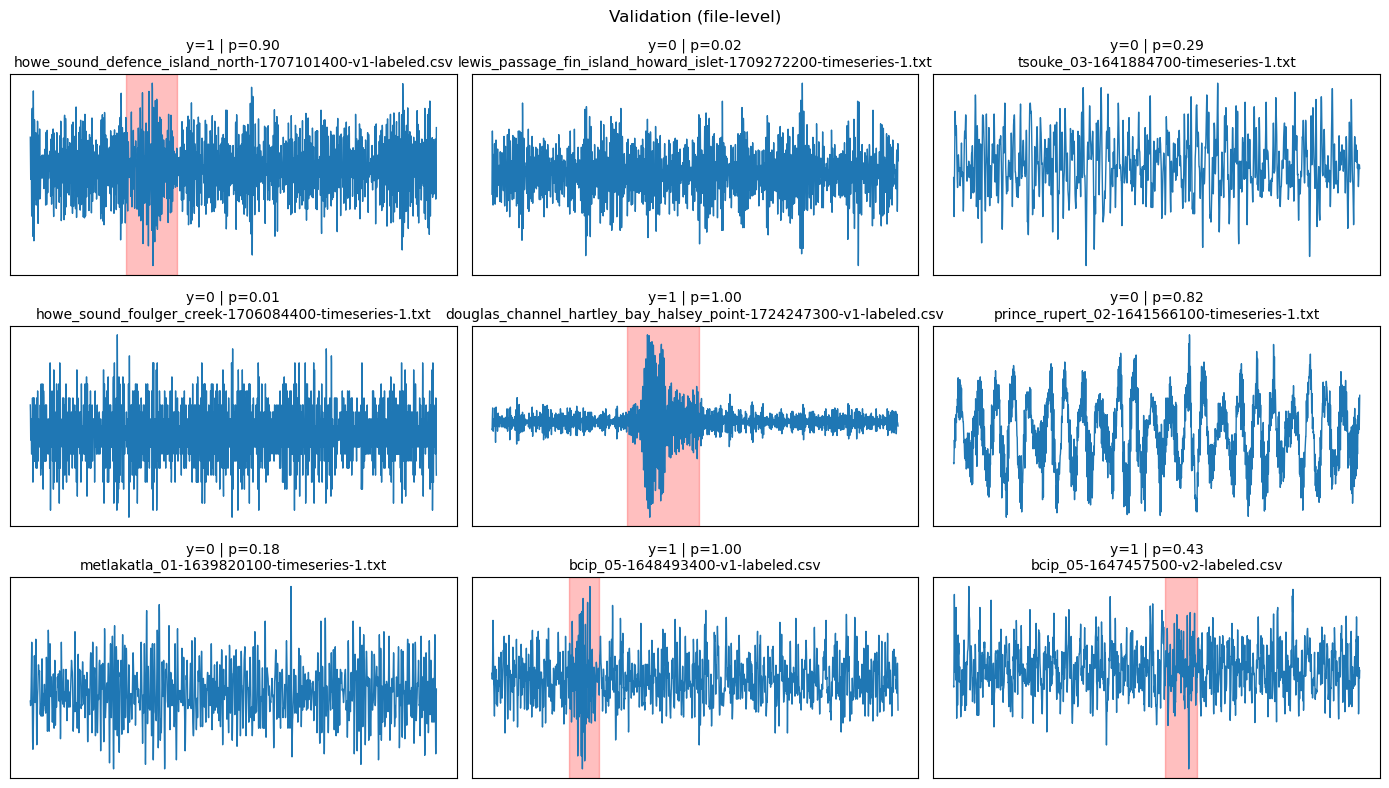

In [20]:
plot_filelevel_grid(valid_ds, yva_prob, yva_true, n=9, title="Validation (file-level)")